# Subjectivity in News Articles
## Zero Shot with LLMs

In [1]:
%%capture
%pip install -U bitsandbytes huggingface_hub

In [ ]:
import os
os.kill(os.getpid(), 9)

In [33]:
from collections import defaultdict
import os
import gc
from pathlib import Path

import csv

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm

from joblib import delayed, Parallel

from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

import optuna
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sentence_transformers import SentenceTransformer
from datasets import Dataset
from huggingface_hub import notebook_login
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, RobertaTokenizerFast, RobertaForSequenceClassification, pipeline, get_linear_schedule_with_warmup, BitsAndBytesConfig, AutoModelForCausalLM
from copy import deepcopy

In [2]:
SEED = 42
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

Using device: cuda


In [19]:
data_folder = '/kaggle/input/clef2025-checkthat/data' # data
dataset = pd.DataFrame(columns=['sentence_id','sentence','label','lang','split'])

for language in os.listdir(data_folder):
    for filename in os.listdir(f"{data_folder}{os.sep}{language}"):
        if '.tsv' in filename:
            abs_path = f"{data_folder}{os.sep}{language}{os.sep}{filename}"
            df = pd.read_csv(abs_path, sep='\t', quoting=csv.QUOTE_NONE)
            if 'solved_conflict' in df.columns:
                df.drop(columns=['solved_conflict'], inplace=True)
            df['lang'] = language
            df['split'] = Path(filename).stem
            dataset = pd.concat([dataset, df], axis=0)

In [20]:
dataset = dataset[dataset['lang'] == 'english']

In [21]:
train = dataset[dataset['split'].str.contains('train')].copy()
dev = dataset[dataset['split'].str.contains('dev')].copy()
test = dataset[dataset['split'].str.contains('dev_test')].copy()

print(f"Train: {train.shape}")
print(f"Dev: {dev.shape}")
print(f"Test: {test.shape}")

Train: (830, 5)
Dev: (946, 5)
Test: (484, 5)


In [22]:
print(f"Train: {train['label'].value_counts(normalize=True)}")
print(f"Dev: {dev['label'].value_counts(normalize=True)}")
print(f"Test: {test['label'].value_counts(normalize=True)}")

Train: label
OBJ     0.640964
SUBJ    0.359036
Name: proportion, dtype: float64
Dev: label
OBJ     0.617336
SUBJ    0.382664
Name: proportion, dtype: float64
Test: label
OBJ     0.747934
SUBJ    0.252066
Name: proportion, dtype: float64


In [23]:
train.loc[:, 'label'] = train['label'].apply(lambda x: 0 if x == 'OBJ' else 1)
dev.loc[:, 'label'] = dev['label'].apply(lambda x: 0 if x == 'OBJ' else 1)
test.loc[:, 'label'] = test['label'].apply(lambda x: 0 if x == 'OBJ' else 1)

In [24]:
train['label'] = train['label'].astype(int)
dev['label'] = dev['label'].astype(int)
test['label'] = test['label'].astype(int)

In [8]:
notebook_login()

In [25]:
train.head()

,sentence_id,sentence,label,lang,split
0,b9e1635a-72aa-467f-86d6-f56ef09f62c3,Gone are the days when they led the world in r...,1,english,train_en
1,f99b5143-70d2-494a-a2f5-c68f10d09d0a,The trend is expected to reverse as soon as ne...,0,english,train_en
2,4076639c-aa56-4202-ae0f-9d9217f8da68,But there is the specious point again.,0,english,train_en
3,b057c366-698e-419d-a284-9b16d835c64e,He added he wouldn’t be surprised to see a new...,0,english,train_en
4,a5a9645e-7850-41ba-90a2-5def725cd5b8,"Not less government, you see; the same amount ...",1,english,train_en


In [10]:
def clear_cache():
        """
        Clears the GPU cache and performs garbage collection.
        This method uses PyTorch's `torch.cuda.empty_cache()` to release all unoccupied cached memory
        currently held by the caching allocator so that those can be used in other GPU applications.
        It also calls Python's garbage collector to free up memory that is no longer in use.
        Returns:
            None
        """
        torch.cuda.empty_cache()

        with torch.no_grad():
            torch.cuda.empty_cache()

        gc.collect()

In [11]:
def load_model(model_card: str, with_4_bit: bool = True) -> tuple:
        """
        Loads a pre-trained model and its tokenizer with optional 4-bit quantization.

        Args:
            model_card (str): The identifier of the pre-trained model to load.
            with_4_bit (bool, optional): If True, loads the model with 4-bit quantization.
                                         If False, loads the model with 8-bit quantization.
                                         Defaults to True.

        Returns:
            tuple: A tuple containing the loaded model and tokenizer.
        """
        # Clear cache
        clear_cache()

        # Setup the quantization config
        quantization_config = BitsAndBytesConfig(load_in_8bit=True)
        if with_4_bit:
            quantization_config = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_quant_type="fp4",
                bnb_4bit_compute_dtype=torch.bfloat16
            )
        # Load tokenizer
        tokenizer = AutoTokenizer.from_pretrained(model_card)
        # Load the model
        model = AutoModelForCausalLM.from_pretrained(model_card, quantization_config=quantization_config)
        # Set the model to evaluation (inference) mode
        model.eval()

        return model, tokenizer

In [12]:
model_card = 'mistralai/Mistral-7B-Instruct-v0.3'
mistral_model, mistral_tokenizer = load_model(model_card, with_4_bit=True)

device = mistral_model.device
print(f'Model loaded on {device}')

tokenizer_config.json:   0%|          | 0.00/141k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

Model loaded on cuda:0


In [29]:
prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for subjectivity detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. 
        A sentence is subjective if its content is based on or influenced by personal feelings, tastes, or opinions (asnwer with YES). Otherwise, the sentence is objective (answer with NO).
        More precisely, a sentence is subjective if one or more of the following conditions apply:
        1. expresses an explicit personal opinion from the author (e.g., speculations to draw conclusions);
        2. includes sarcastic or ironic expressions;
        3. gives exhortations of personal auspices;
        4. contains discriminating or downgrading expressions;
        5. contains rhetorical figures that convey the author’s opinion.
        
        The following ambiguous cases are objective: thirdparty’s opinions, comments that do not draw conclusions and leave open questions, and factual conclusions.
        Note 1: Reported speech verbatim cannot contain elements that we identify as markers of subjectivity as it is not content created by thewriter, and, thus, is objective.
        Note 2: Personal feelings, emotions, or mood of the author, without conveying opinions on the matter, are considered objective since the author is the most reliable source for information regarding their own emotions. Emotion-carrying statements are not excluded since they frequently occur in news articles and excluding them from the corpus would turn it less useful in real application scenarios.
        
        Respond only YES or NO.

        TEXT:
        {text}

        ANSWER:
        """
    }
]

In [36]:

def prepare_prompts(texts: pd.Series, prompt_template: list, tokenizer: AutoTokenizer):
    """
    Prepares prompts by applying a chat template to a series of input texts.

    Args:
        texts (pd.Series): A pandas Series containing the input texts.
        prompt_template (list): A list representing the prompt template with placeholders.
        tokenizer (AutoTokenizer): An instance of the AutoTokenizer used to tokenize the prompts.

    Returns:
        list: A list of tokenized prompts ready for generation.
    """
    # Store the prompts
    prompts = []
    # Iterate over the input texts
    for text in texts:

        # Create a deepcopy of the prompt template
        prompt_with_text = deepcopy(prompt_template)

        # Replace the placeholder with the input text
        prompt_with_text[1]['content'] = prompt_with_text[1]['content'].replace('{text}', text)

        # Apply the chat template to the input text
        full_prompt = tokenizer.apply_chat_template(
            prompt_with_text,
            tokenize=True,
            add_generation_prompt=True,
            return_dict=True,
            return_tensors="pt")
        # Move the full prompt to the device
        full_prompt = full_prompt.to(device)
        # Append the full prompt to the list of prompts
        prompts.append(full_prompt)

    return prompts

In [37]:
prompts = prepare_prompts(texts=train['sentence'], prompt_template=prompt, tokenizer=mistral_tokenizer)

print(f"Prompt example: \n{mistral_tokenizer.decode(prompts[0].input_ids[0], skip_special_tokens=True)}")

Prompt example: 
You are an annotator for subjectivity detection.

Your task is to classify input text as containing sexism or not. 
        A sentence is subjective if its content is based on or influenced by personal feelings, tastes, or opinions (asnwer with YES). Otherwise, the sentence is objective (answer with NO).
        More precisely, a sentence is subjective if one or more of the following conditions apply:
        1. expresses an explicit personal opinion from the author (e.g., speculations to draw conclusions);
        2. includes sarcastic or ironic expressions;
        3. gives exhortations of personal auspices;
        4. contains discriminating or downgrading expressions;
        5. contains rhetorical figures that convey the author’s opinion.
        
        The following ambiguous cases are objective: thirdparty’s opinions, comments that do not draw conclusions and leave open questions, and factual conclusions.
        Note 1: Reported speech verbatim cannot contain

In [38]:
def generate_responses(model: AutoModelForCausalLM, tokenizer: AutoTokenizer, prompt_examples: list, max_new_tokens: int = 1000) -> list:
    """
    Generates responses for a list of prompt examples using a specified language model and tokenizer.

    Args:
        model (AutoModelForCausalLM): The language model to use for generating responses.
        tokenizer (AutoTokenizer): The tokenizer associated with the language model.
        prompt_examples (list): A list of prompt examples to generate responses for.
        max_new_tokens (int, optional): The maximum number of new tokens to generate for each prompt. Defaults to 1000.

    Returns:
        list: A list of generated responses corresponding to each prompt example.
    """
    answers = []
    for prompt in tqdm(prompt_examples):
        response = model.generate(**prompt, max_new_tokens=max_new_tokens, pad_token_id=tokenizer.eos_token_id)
        answers.append(response)
    return answers

In [39]:
answers = generate_responses(model=mistral_model, tokenizer=mistral_tokenizer, prompt_examples=prompts)

100%|██████████| 830/830 [17:58<00:00,  1.30s/it]


In [40]:
def process_response(response: torch.Tensor, tokenizer: AutoTokenizer) -> int:
    """
    Processes the response tensor and determines if it contains a positive indication.

    Args:
        response (torch.Tensor): The tensor containing the response from the model.
        tokenizer (AutoTokenizer): The tokenizer used to decode the response tensor.

    Returns:
        int: Returns 1 if the decoded response contains 'YES' after 'ANSWER', otherwise returns 0.
    """
    response_text = tokenizer.decode(response[0])
    if 'YES' in response_text.split('ANSWER')[-1]:
        return 1
    elif 'NO' in response_text.split('ANSWER')[-1]:
        return 0
    else:
        return -1 # Model answer is not compliant with the classification task

In [43]:
import re
def get_generated_response(response: torch.Tensor, tokenizer: AutoTokenizer) -> str:
    """
    Decodes a tensor response into a cleaned string.

    Args:
        response (torch.Tensor): The tensor containing the response to decode.
        tokenizer (AutoTokenizer): The tokenizer used to decode the response.

    Returns:
        str: The cleaned and decoded response string.
    """
    # Get the decoded response text
    response_text = tokenizer.decode(response[0])
    # Assign the default tokenizer name
    tokenizer_name = 'mistral'
    # Check if the tokenizer has a name or path attribute
    if hasattr(tokenizer, 'name_or_path'):
        # In that case, assign the name or path to the tokenizer_name variable
        tokenizer_name = tokenizer.name_or_path
    # If the tokenizer name contains 'llama', split the response text with the special tokens of the Llama model
    if 'llama' in tokenizer_name:
        response_text = response_text.split('<|end_header_id|>')[-1]
    # If it is mistral, split the response text with the special tokens of the Mistral model
    else:
        response_text = response_text.split('[/INST]')[-1]

    # Remove the special tokens from the response text
    cleaned_string = re.sub(r'</s>', '', response_text).strip()
    # If the tokenizer name contains 'llama', remove the special token '<|eot_id|>'
    if 'llama' in tokenizer_name:
        cleaned_string = re.sub(r'<\|eot_id\|>', '', cleaned_string).strip()
    return cleaned_string

In [44]:
batch_predictions = [process_response(response=item, tokenizer=mistral_tokenizer) for item in answers]
generated_answers = [get_generated_response(response=item, tokenizer=mistral_tokenizer) for item in answers]

In [46]:
train.head()

,sentence_id,sentence,label,lang,split
0,b9e1635a-72aa-467f-86d6-f56ef09f62c3,Gone are the days when they led the world in r...,1,english,train_en
1,f99b5143-70d2-494a-a2f5-c68f10d09d0a,The trend is expected to reverse as soon as ne...,0,english,train_en
2,4076639c-aa56-4202-ae0f-9d9217f8da68,But there is the specious point again.,0,english,train_en
3,b057c366-698e-419d-a284-9b16d835c64e,He added he wouldn’t be surprised to see a new...,0,english,train_en
4,a5a9645e-7850-41ba-90a2-5def725cd5b8,"Not less government, you see; the same amount ...",1,english,train_en


In [47]:
models_predictions = pd.DataFrame({
    'text': train['sentence'],
    'original_labels': train['label'],
    'Mistralv3_zero_shot_labels': batch_predictions,
    'Mistralv3_zero_shot_answers': generated_answers
})

In [48]:
models_predictions

,text,original_labels,Mistralv3_zero_shot_labels,Mistralv3_zero_shot_answers
0,Gone are the days when they led the world in r...,1,0,NO
1,The trend is expected to reverse as soon as ne...,0,0,NO
2,But there is the specious point again.,0,1,YES
3,He added he wouldn’t be surprised to see a new...,0,0,NO
4,"Not less government, you see; the same amount ...",1,1,YES
...,...,...,...,...
825,Local governments and their financing vehicles...,1,0,NO
826,That fact alone underscores the biggest proble...,1,0,NO
827,Presumably it had in mind those Russian offici...,1,1,YES
828,"From bad taxation, reckless borrowing and reck...",1,0,NO


In [ ]:
mistal_base_metrics = compute_metrics(responses=answers, y_true=original_labels, tokenizer=mistral_tokenizer)
print(f"Mistral v3 Zero-Shot Metrics: {mistal_base_metrics}")

Correggere la compute metrics function,
possiamo eliminare il richiamo alla funzione process_response visto che é giá stato fatto

In [54]:
import sklearn

def compute_metrics(responses: list, y_true: list, tokenizer: AutoTokenizer) -> dict:
    """
    Compute the accuracy and fail ratio of the model's predictions.

    Args:
        responses (list): A list of responses generated by the model.
        y_true (list): A list of true labels corresponding to the responses.

    Returns:
        dict: A dictionary containing the accuracy and fail ratio of the predictions.
            - 'accuracy' (float): The proportion of correct predictions.
            - 'fail_ratio' (float): The proportion of incorrect answers which are not compliant with the classification task.
    """
    y_pred = [process_response(response=response, tokenizer=tokenizer) for response in responses]
    accuracy = (np.array(y_pred) == np.array(y_true)).mean()

    f1_score = sklearn.metrics.f1_score(y_true, y_pred)

    
    return {'accuracy': accuracy, 'f1_score': f1_score}

In [55]:
mistal_base_metrics = compute_metrics(responses=answers, y_true=train['label'], tokenizer=mistral_tokenizer)

print(f"Mistral v3 Zero-Shot Metrics: {mistal_base_metrics}")

Mistral v3 Zero-Shot Metrics: {'accuracy': 0.7024096385542169, 'f1_score': 0.4969450101832994}


In [57]:
cm = confusion_matrix(train['label'], batch_predictions)

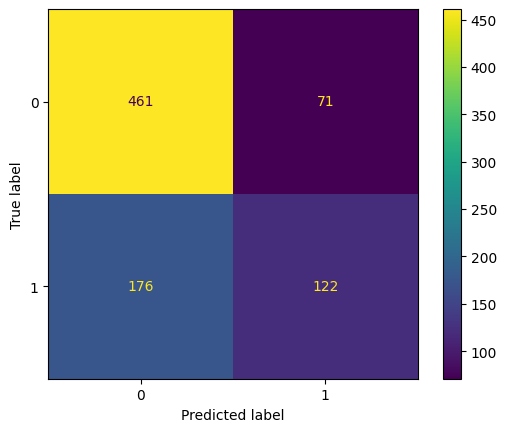

In [59]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# llama 

In [61]:
#load Llama3.1 8B model
model_card = 'meta-llama/Meta-Llama-3.1-8B-Instruct'
llama_model, llama_tokenizer = load_model(model_card, with_4_bit=True)

device = llama_model.device
print(f'Model loaded on {device}')

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model-00001-of-00004.safetensors:  25%|##5       | 1.25G/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

Model loaded on cuda:0


In [62]:
prompts = prepare_prompts(texts=train['sentence'], prompt_template=prompt, tokenizer=llama_tokenizer)

print(f"Prompt example: \n{llama_tokenizer.decode(prompts[0].input_ids[0], skip_special_tokens=True)}")

Prompt example: 
system

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are an annotator for subjectivity detection.user

Your task is to classify input text as containing sexism or not. 
        A sentence is subjective if its content is based on or influenced by personal feelings, tastes, or opinions (asnwer with YES). Otherwise, the sentence is objective (answer with NO).
        More precisely, a sentence is subjective if one or more of the following conditions apply:
        1. expresses an explicit personal opinion from the author (e.g., speculations to draw conclusions);
        2. includes sarcastic or ironic expressions;
        3. gives exhortations of personal auspices;
        4. contains discriminating or downgrading expressions;
        5. contains rhetorical figures that convey the author’s opinion.
        
        The following ambiguous cases are objective: thirdparty’s opinions, comments that do not draw conclusions and leave open questions, and f

In [63]:
answers = generate_responses(model=llama_model, tokenizer=llama_tokenizer, prompt_examples=prompts)

100%|██████████| 830/830 [17:25<00:00,  1.26s/it]


In [64]:
batch_predictions = [process_response(response=item, tokenizer=llama_tokenizer) for item in answers]
generated_answers = [get_generated_response(response=item, tokenizer=llama_tokenizer) for item in answers]

In [65]:
models_predictions['Llama3_zero_shot_labels'] = batch_predictions
models_predictions['Llama3_zero_shot_answers'] = generated_answers

In [74]:
llama_base_metrics = compute_metrics(responses=answers, y_true=train['label'], tokenizer=llama_tokenizer)
print(f"Llama3 Zero-Shot Metrics: {llama_base_metrics}")

Llama3 Zero-Shot Metrics: {'accuracy': 0.7072289156626506, 'f1_score': 0.5699115044247788}


# Stima numero token 

In [79]:
full_prompt = llama_tokenizer.apply_chat_template(
                prompt,
                tokenize=True,
                add_generation_prompt=True,
                return_dict=True,
                return_tensors="pt")

In [82]:
full_prompt['input_ids']

tensor([[128000, 128006,   9125, 128007,    271,  38766,   1303,  33025,   2696,
             25,   6790,    220,   2366,     18,    198,  15724,   2696,     25,
            220,   1627,  10263,    220,   2366,     19,    271,   2675,    527,
            459,  37142,    859,    369,   3917,   1968,  18468,     13, 128009,
         128006,    882, 128007,    271,   7927,   3465,    374,    311,  49229,
           1988,   1495,    439,   8649,  69095,    477,    539,     13,    720,
            286,    362,  11914,    374,  44122,    422,   1202,   2262,    374,
           3196,    389,    477,  28160,    555,   4443,  16024,     11,  36263,
             11,    477,  18463,    320,  66636,   6703,    449,  14410,    570,
          18715,     11,    279,  11914,    374,  16945,    320,   9399,    449,
           5782,   4390,    286,   4497,  24559,     11,    264,  11914,    374,
          44122,    422,    832,    477,    810,    315,    279,   2768,   4787,
           3881,    512,    

In [84]:
len(full_prompt['input_ids'][0])

345

In [86]:
(450 * len(train)) + (5 * len(train))

377650

OpenaAI 4o mini